# Predicting Precipitation in San Jose, CA - Modeling
The goal of this project will be to predict the chance of precipitation in San Jose using various weather features. That dataset is taken from the [NOAA](https://www.ncdc.noaa.gov/data-access/quick-links#loc-clim). I will use a 
decision tree as well as a random forest model and compare which model perform better.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sqlalchemy import create_engine
import time
import warnings
warnings.filterwarnings('ignore')

import helpers as hp
from config import usr, pwd, url, port, db, table

%matplotlib inline

## Load Dataset
Load cleaned dataset.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {table};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

## Outlier Analysis
Analyze the outliers for the continous variables and decide how to correct for them. Only consider the continuous variables, less snow.

In [6]:
non_snow_variables = df.columns.tolist()
variables_to_remove = ['DailyWeather', 'DailySnowDepth', 'DailySnowfall']
for var in variables_to_remove:
    non_snow_variables.remove(var)

In [7]:
df_continuous = df.loc[:, non_snow_variables].copy()

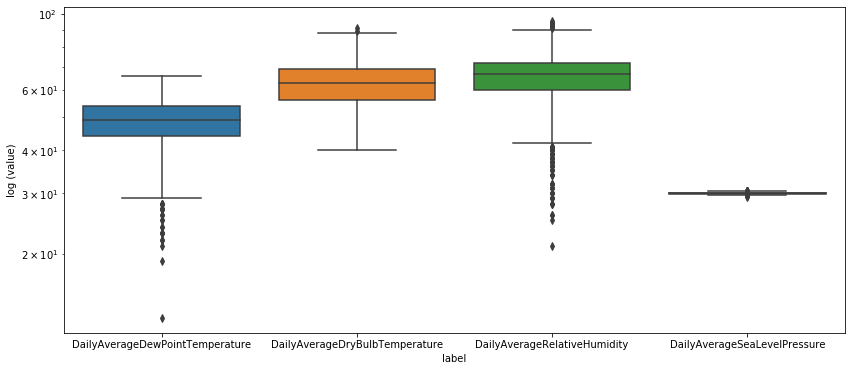

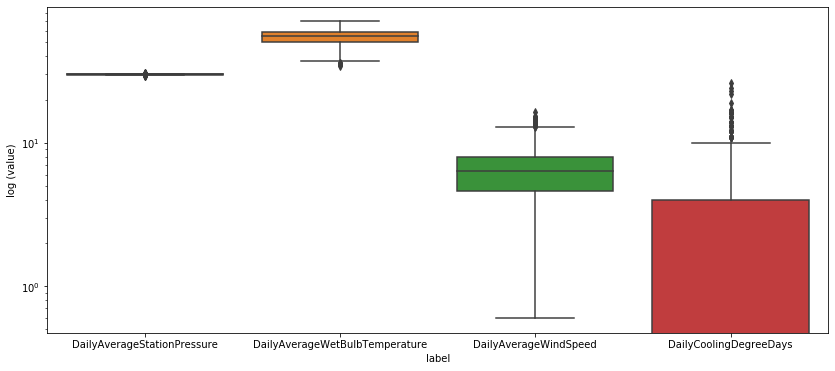

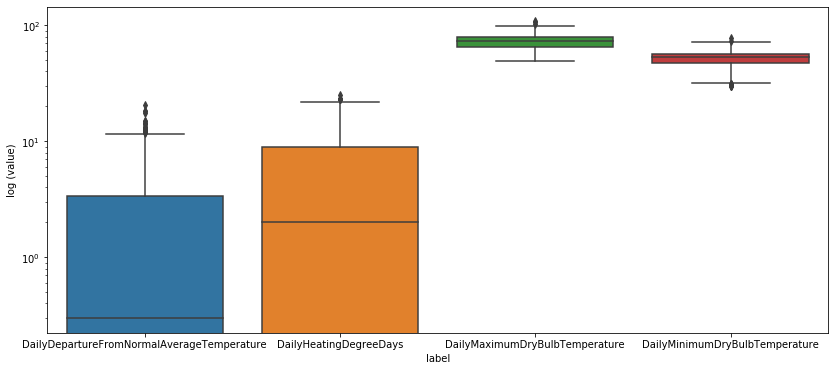

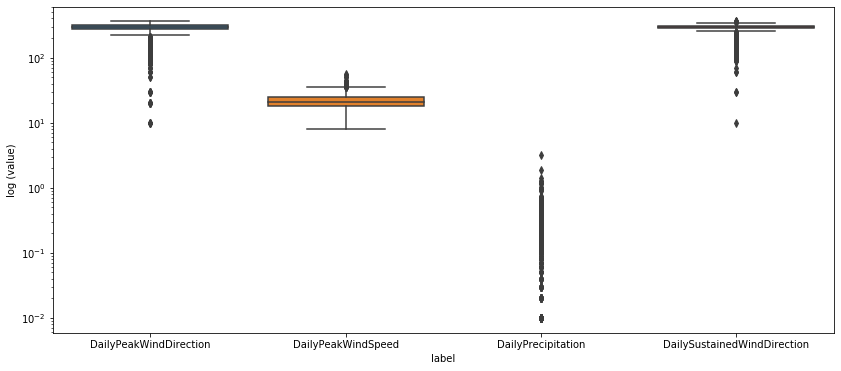

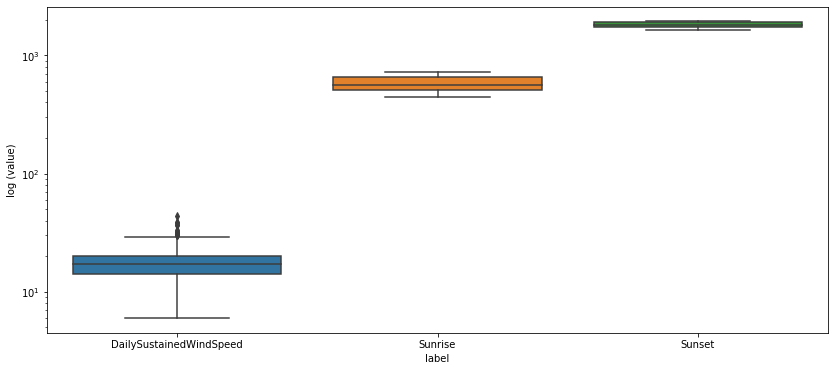

In [8]:
hp.look_for_outliers(df_continuous, df_continuous.columns.to_list(), max_boxes=4, log_scale=True)

**Observations:** Most of the continous variables show outliers. As long as those outliers are not too extreme, the should be ok to include, since I am using decision tree and random forest models. The two columns that are worriesome are: _DailyAverageDewPointTemperature_ and _DailyAverageRelativeHumidity_. Let's inspect these two columns in more detail.

In [9]:
df_continuous.loc[:, ['DailyAverageDewPointTemperature', 'DailyAverageRelativeHumidity']].describe().T

,count,mean,std,min,25%,50%,75%,max
DailyAverageDewPointTemperature,1798.0,48.263626,7.445706,13.0,44.0,49.0,54.0,66.0
DailyAverageRelativeHumidity,1798.0,65.586207,11.150215,21.0,60.0,67.0,72.0,95.0


In [10]:
df_continuous[df_continuous['DailyAverageDewPointTemperature'] == df_continuous['DailyAverageDewPointTemperature'].min()].T

,362
DailyAverageDewPointTemperature,13.00
DailyAverageDryBulbTemperature,46.00
DailyAverageRelativeHumidity,28.00
DailyAverageSeaLevelPressure,30.17
DailyAverageStationPressure,30.11
DailyAverageWetBulbTemperature,34.00
DailyAverageWindSpeed,5.80
DailyCoolingDegreeDays,0.00
DailyDepartureFromNormalAverageTemperature,-4.80
DailyHeatingDegreeDays,19.00


**Observations:**

**-due point:** The low minimum due point could be explained by the low temperature and low average humidity. Therefore, this outlier makes sense.

**-humditity:** Most of the time the humidity for San Jose is above 60%. The minimum humidity of 21% could have been due to an exceptionally dry day. It is not unreasonable.

### _DailyWeather_
Inspect the distribution of _DailyPrecipitation_ when _DailyWeather_ is Unknown.

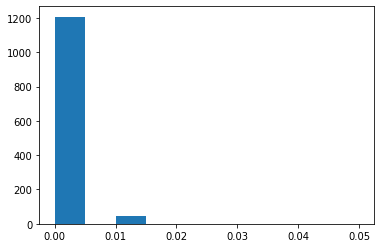

In [11]:
plt.hist(df.loc[df['DailyWeather'] == 'Unknown', 'DailyPrecipitation'])
plt.show()

In [12]:
df.loc[df['DailyWeather'] == 'Unknown', 'DailyPrecipitation'].unique()

array([0.  , 0.05, 0.01, 0.02])

**Observations:** In the case of Unknown _DailyWeather_, the precipitation amount is either very low or zero. In fact, it is mostly zeros.

## Feature Engineering
### Precipitation Prediction
Create a new column, _PrecipitationChance_. Base this off _DailyWeather_. If _DailyWeather_ equals Unknown, then set _PrecipitionChance_ equal to zero.

In [13]:
df['PrecipitationChance'] = np.zeros(len(df))

In [14]:
df['DailyWeather'].unique()

array(['HZ', 'Unknown', 'RA DZ BR HZ', 'RA DZ BR', 'FG BR HZ', 'BR', 'RA',
       'RA BR', 'BR HZ', 'DZ BR', 'FG BR', 'RA FG BR', 'TS RA BR',
       'RA HZ', 'RA BR HZ', 'TS RA', 'RA FG BR HZ'], dtype=object)

In [15]:
def find_keywords(x):
    value = 0
    precipitation_keywords = ['GR', 'DZ', 'RA', 'UP']
    for keyword in precipitation_keywords:
        if keyword in x:
            value = 1
    return value

In [16]:
df['PrecipitationChance'] = df['DailyWeather'].apply(lambda x: find_keywords(x))

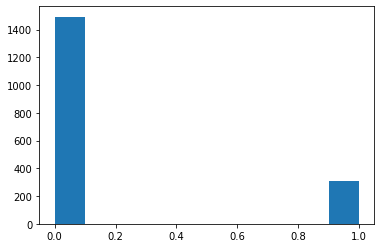

In [17]:
plt.hist(df['PrecipitationChance'])
plt.show()

### Day Duration
Create a column _DayDuration_ by subtraction _Sunset_ from _Sunrise_.

In [18]:
df['DayDuration'] = df['Sunset'] - df['Sunrise']

### Drop Features
Drop the following features from the dataset. They are either redundant or do not apply to San Jose.

In [19]:
features_to_drop = ['DailyDepartureFromNormalAverageTemperature', 
                    'DailyMaximumDryBulbTemperature', 
                    'DailyMinimumDryBulbTemperature', 
                    'DailySnowDepth', 
                    'DailySnowfall', 
                    'Sunset', 
                    'Sunrise', 
                    'DailyWeather']
df.drop(features_to_drop, axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 16 columns):
DailyAverageDewPointTemperature    1798 non-null float64
DailyAverageDryBulbTemperature     1798 non-null float64
DailyAverageRelativeHumidity       1798 non-null float64
DailyAverageSeaLevelPressure       1798 non-null float64
DailyAverageStationPressure        1798 non-null float64
DailyAverageWetBulbTemperature     1798 non-null float64
DailyAverageWindSpeed              1798 non-null float64
DailyCoolingDegreeDays             1798 non-null float64
DailyHeatingDegreeDays             1798 non-null float64
DailyPeakWindDirection             1798 non-null float64
DailyPeakWindSpeed                 1798 non-null float64
DailyPrecipitation                 1798 non-null float64
DailySustainedWindDirection        1798 non-null float64
DailySustainedWindSpeed            1798 non-null float64
PrecipitationChance                1798 non-null int64
DayDuration                        1798 

### Correlation Analysis
Find which features are highly correlated and remove them.

In [21]:
features = df.columns.tolist()
features.remove('PrecipitationChance')

In [22]:
df_corr = df.loc[:, features].corr()

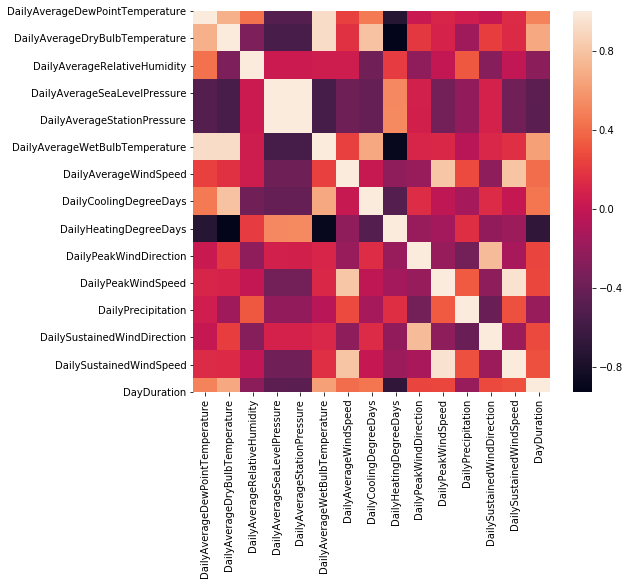

In [23]:
f, axes = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(df_corr, ax=axes)
plt.show()

In [24]:
correlated_columns = hp.find_correlated_features(df, thresh=0.8)

Correlated Columns (r > 0.8):
* DailyAverageStationPressure
* DailyAverageWetBulbTemperature
* DailyHeatingDegreeDays
* DailyPeakWindSpeed
* DailySustainedWindSpeed
11 correlated features will be removed.


In [25]:
df.drop(correlated_columns, axis=1, inplace=True)
features = df.columns.tolist()
features.remove('PrecipitationChance')

In [26]:
df_corr = df.loc[:, features].corr()

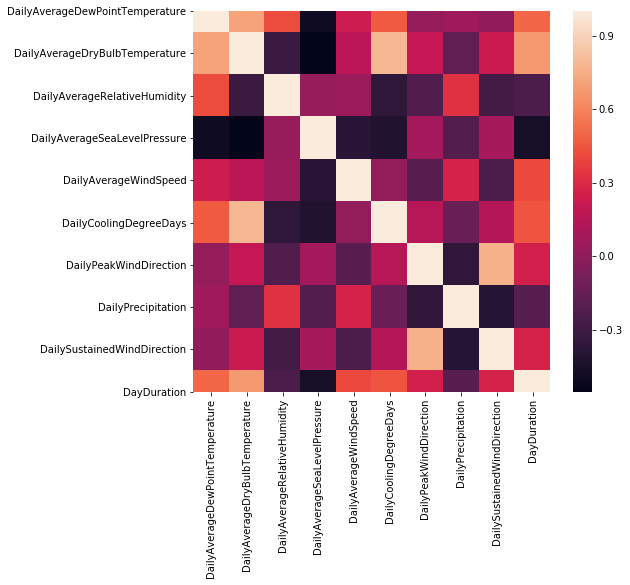

In [27]:
f, axes = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(df_corr, ax=axes)
plt.show()

## Modeling
### Split target and features

In [28]:
X = df.loc[:, features]
y = df['PrecipitationChance']

### Decision Tree Model

In [29]:
start = time.time()
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=len(features),
    max_depth=2
)
cv_scores = cross_val_score(decision_tree, X, y, cv=10)
stop = time.time()
print(cv_scores)
print(f'Mean cv score: {np.mean(cv_scores):0.3f}')
print(f'Execution time: {stop - start:0.3f} s')

[0.96685083 0.96132597 0.96685083 0.95555556 0.93888889 0.96089385
 0.97206704 0.98882682 0.96648045 0.97765363]
Mean cv score: 0.966
Execution time: 0.047 s


### Random Forest Model

In [30]:
start = time.time()
rfc = ensemble.RandomForestClassifier()
cv_scores = cross_val_score(rfc, X, y, cv=10)
stop = time.time()
print(cv_scores)
print(f'Mean cv score: {np.mean(cv_scores):0.3f}')
print(f'Execution time: {stop - start:0.3f} s')

[0.95027624 0.96685083 0.95027624 0.97777778 0.92777778 0.94413408
 0.97765363 0.94972067 0.95530726 0.95530726]
Mean cv score: 0.956
Execution time: 0.184 s


## Conclusions
The decision tree model performs more accurately and also executes more quickly.